In [334]:
from dotenv import load_dotenv
import os
import mysql.connector as mc
import pyodbc
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import plotly.express as px
import plotly.graph_objects as go
from dash import html, dcc

In [2]:
load_dotenv()

True

In [17]:
from jupyter_dash import JupyterDash
app = JupyterDash(__name__)

In [6]:
def runQuery_tidb(query):
    conn = mc.connect(host=os.getenv('TIDB_HOST'),
                      port=os.getenv('TIDB_PORT'),
                      user=os.getenv('TIDB_USER'),
                      password=os.getenv('TIDB_PW'),
                      database=os.getenv('TIDB_DEFAULT_DATABASE'))
    cur = conn.cursor()
    cur.execute(query)
    ### modify results
    columns = []
    for i in range(len(cur.description)):
        desc = cur.description[i]
        columns.append(str(desc[0]))
    data = pd.DataFrame(cur.fetchall(), columns=columns)
    ### disconnect and return
    # conn.disconnect
    return data

In [5]:
def runQuery_dremio(query):
    host = os.getenv('DREMIO_HOST')
    port = os.getenv('DREMIO_PORT')
    uid = os.getenv('DREMIO_USER')
    pwd = os.getenv('DREMIO_PW')
    driver = os.getenv('DREMIO_DRIVER')

    conn = pyodbc.connect(
        "Driver={};ConnectionType=Direct;HOST={};PORT={};AuthenticationType=Plain;UID={};PWD={}".format(driver, host, port, uid, pwd),
        autocommit=True)

    data = pd.read_sql(query, conn)
    return data

In [10]:
default_start = date.today() - timedelta(days=8)
default_end = date.today() - timedelta(days=1)

In [11]:
def get_raw_data(start, end):
    data = runQuery_tidb(f"""
    SELECT
    DATE_FORMAT(CONVERT_TZ(FROM_UNIXTIME(psc.cl_date_clicked), 'GMT', 'US/Central'), '%Y-%m-%d') AS datecl,

    psc.a_id AS project_id, a.a_name AS project_name, CONCAT('[',psc.a_id,'] ',a.a_name) AS project,
    a.d_id AS merchant_id, d.d_company AS merchant_name, CONCAT('[',a.d_id,'] ',d.d_company) AS merchant,
    psc.ps_id, ps.ps, psc.pss_id, CASE WHEN psc.pss_id=0 OR psc.pss_id IS NULL THEN 'Unknown' ELSE pss.pss END AS pss,
    psc.co_id, co.co_code_alpha3, co.co_name,

    round(SUM(psc.cl_revenue_xe * (a.d_id != 162784) * (psc.ps_id NOT IN (45, 288)) * (psc.pss_id NOT IN (80)
    OR psc.pss_id IS null) * (psc.cl_refunded = 0)* ((cl_recurring_type != 'repeat') * (cl_recurring_type != 'post_trial'))), 2) AS PV,

    round(SUM(if((a.a_custom_settings RLIKE 'vat'
    AND a.a_custom_settings RLIKE 'mor')
    AND d.d_rolling_reserve_payable=1, (psc.cl_commission_xe-psc.cl_user_commission_xe)-IFNULL((tt_tax_amount/cu.cu_rate),tt_tax_amount), IF((a.a_custom_settings RLIKE 'vat'
    AND a.a_custom_settings RLIKE 'mor')
    AND d.d_rolling_reserve_payable=0, (cl_gross_margin_xe-cl_user_commission_xe) - IFNULL((tt_tax_amount/cu.cu_rate),tt_tax_amount), IF(d.d_rolling_reserve_payable=1, (cl_commission_xe-cl_user_commission_xe), (cl_gross_margin_xe-cl_user_commission_xe))))), 2) AS rev

    FROM 
    (
        SELECT * FROM ti_paymentwall.ps_clicks 
        WHERE cl_date_clicked >= UNIX_TIMESTAMP(CONVERT_TZ('{start}', 'US/Central', 'GMT'))
        AND cl_date_clicked < UNIX_TIMESTAMP(CONVERT_TZ('{end}' + INTERVAL 1 DAY, 'US/Central', 'GMT'))
        AND cl_tracked = 1 AND cl_approved = 1 AND cl_fraud = 0
        AND (pss_id NOT IN (69) OR pss_id IS NULL)
    ) psc

    INNER JOIN 
    (
        SELECT * FROM ti_paymentwall.applications
        WHERE a_internal_usage != 1
    ) a ON psc.a_id = a.a_id

    INNER JOIN 
    (
        SELECT * FROM ti_paymentwall.developers
    ) d ON a.d_id = d.d_id

    LEFT JOIN 
    (
        SELECT pss_id, CONCAT('[',pss_id,'] ',pss_name) AS pss FROM ti_paymentwall.ps_subaccounts
    ) pss ON psc.pss_id = pss.pss_id

    INNER JOIN 
    (
        SELECT ps_id, CONCAT('[',ps_id,'] ',ps_name) AS ps FROM ti_paymentwall.payment_systems 
    ) ps ON psc.ps_id = ps.ps_id

    INNER JOIN 
    (
        SELECT co_id, co_code_alpha3, co_name FROM ti_paymentwall.countries 
    ) co ON psc.co_id = co.co_id

    LEFT JOIN ti_paymentwall.taxable_transactions tt ON psc.cl_id = tt.cl_id
    LEFT JOIN ti_paymentwall.currencies cu on psc.cu_id = cu.cu_id

    GROUP BY datecl, psc.a_id, a.a_name, project, a.d_id, d.d_company, merchant, psc.ps_id, ps.ps, psc.pss_id, pss.pss, psc.co_id, co.co_code_alpha3, co.co_name
    """)

    return data

In [75]:
data = get_raw_data(default_start, default_end)

In [76]:
data.head()

,datecl,project_id,project_name,project,merchant_id,merchant_name,merchant,ps_id,ps,pss_id,pss,co_id,co_code_alpha3,co_name,PV,rev
0,2022-04-20,370261,Neocraft,[370261] Neocraft,162784,Terminal3,[162784] Terminal3,132,[132] Gateway,73.0,[73] CC_CENTRAL,11,ARG,Argentina,0.00,0.15
1,2022-04-23,385207,Superrnet,[385207] Superrnet,244918,Hypernet,[244918] Hypernet,141,[141] UnionPay,2.0,[2] Veritrans,90,HKG,Hong Kong,1.99,0.18
2,2022-04-22,68275,Gameforge 4D GmbH,[68275] Gameforge 4D GmbH,62076,Gameforge 4D GmbH,[62076] Gameforge 4D GmbH,132,[132] Gateway,21.0,[21] CC_POLK,71,FRA,France,417.06,5.31
3,2022-04-22,303905,Goodgame Subscriptions,[303905] Goodgame Subscriptions,54061,Altigi GmbH,[54061] Altigi GmbH,226,[226] Oxford/ SEPA direct debit,42.0,[42] PPRO,15,AUT,Austria,0.00,0.08
4,2022-04-22,335920,Neocraft Limited,[335920] Neocraft Limited,267039,Neocraft Limited,[267039] Neocraft Limited,218,[218] Poli,NaN,Unknown,14,AUS,Australia,15.58,1.49


In [100]:
def graph_project_distribution(df):
    by_projects = df
    by_projects['project_id_str'] = '[' + by_projects['project_id'].astype(str) + ']'
    by_projects = pd.DataFrame(by_projects.groupby(['project','project_id_str']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    by_projects_graph = px.pie(by_projects, values='PV', names='project')
    by_projects_graph.update_traces(direction='clockwise', text=by_projects['project_id_str'], textposition='inside', textinfo='text+percent',
                                    hovertemplate=None, hoverinfo="label+value+percent")
    by_projects_graph.update_layout(uniformtext_minsize=11, uniformtext_mode='hide', showlegend=False, #, legend_title_text="Project", title_text="Projects' Contribution to Total Volume",
                                    margin=dict(l=20, r=20, t=20, b=20))
    return by_projects_graph

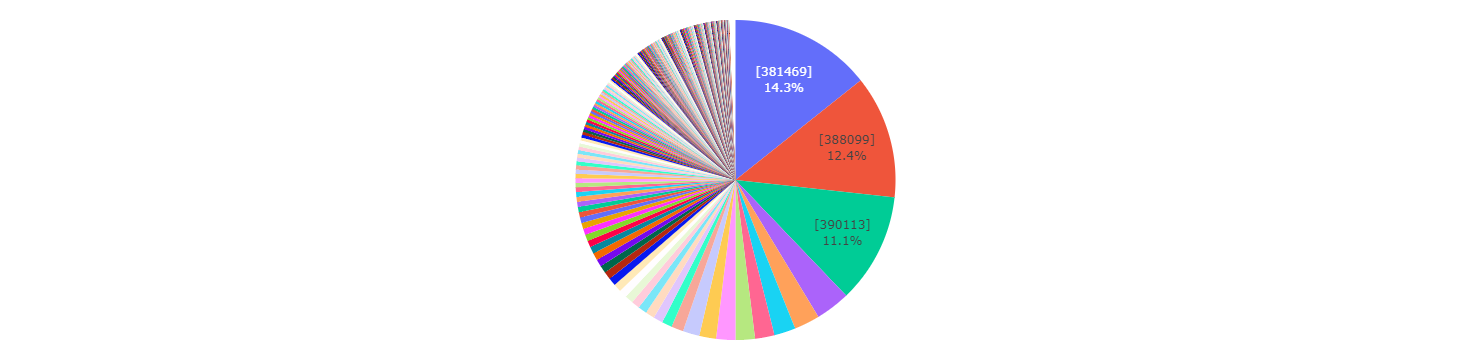

In [101]:
graph_project_distribution(data)

In [329]:
def graph_ps_distribution(df):
    by_ps = pd.DataFrame(df.groupby(['ps','pss']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    by_ps_graph = px.treemap(by_ps, path=[px.Constant("TOTAL"),'ps', 'pss'], values='PV', color='ps' #,title="Payment Systems' Contribution to Total Volume"
                            )
    by_ps_graph.update_traces(hovertemplate=None, hoverinfo="label+value+percent root+percent entry+percent parent")
    by_ps_graph.update_layout(margin=dict(l=20, r=20, t=20, b=20))
    return by_ps_graph

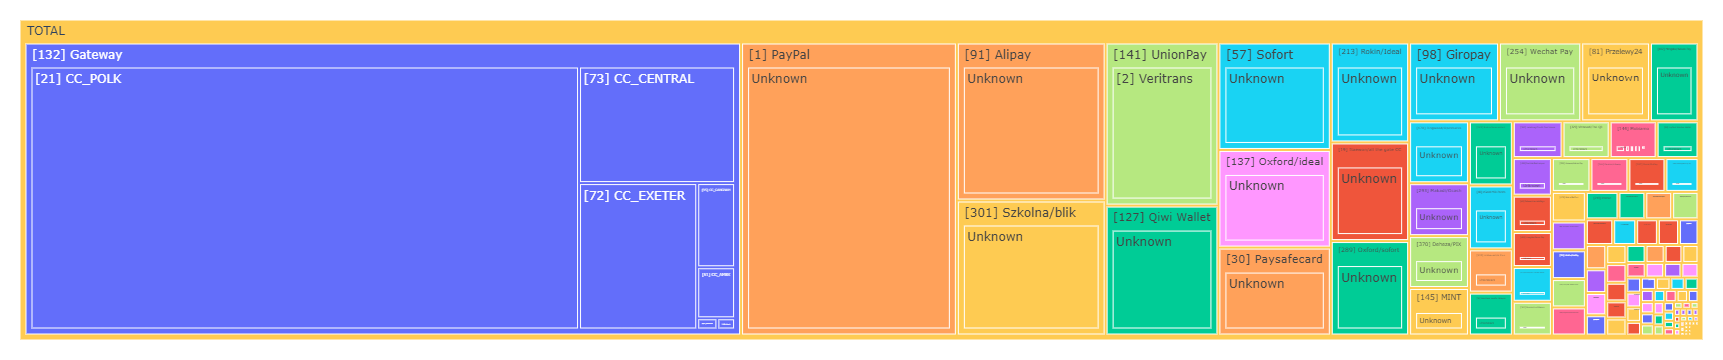

In [330]:
graph_ps_distribution(data)

In [260]:
def graph_countries_distribution(df):
    by_countries = pd.DataFrame(df.groupby(['co_name','co_code_alpha3']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    by_countries['PV'] = by_countries['PV'].astype(float)
    by_countries['text'] = by_countries['co_name'] + '<br>' + by_countries["PV"].map('{:,.2f}'.format) #hover text
        
    graph_countries_distribution = go.Figure(data=go.Choropleth(
        locations=by_countries['co_code_alpha3'], # Spatial coordinates
        z = by_countries['PV'], # Data to be color-coded
        colorscale='Reds'
    ))
    graph_countries_distribution.update_traces(showscale=False, hovertemplate = by_countries['text'])
    graph_countries_distribution.update_layout(margin={"r":20,"t":20,"l":20,"b":20})
    graph_countries_distribution.update_geos(fitbounds="locations", visible=False)
    
    return graph_countries_distribution

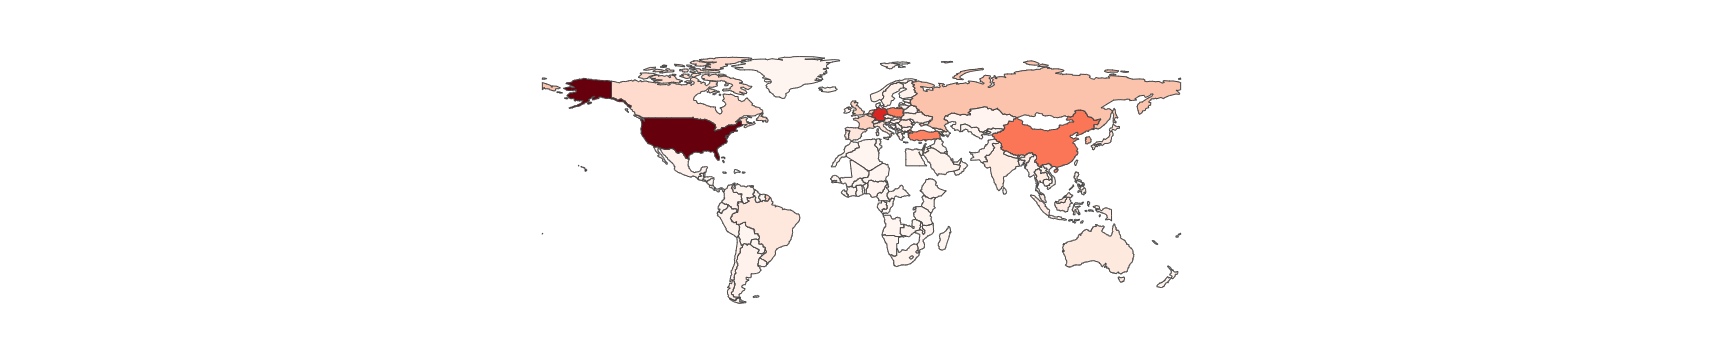

In [261]:
graph_countries_distribution(data)

In [258]:
def graph_countries_distribution(df):
    by_countries = pd.DataFrame(df.groupby(['co_name','co_code_alpha3']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    by_countries['PV'] = by_countries['PV'].astype(float)
    by_countries['text'] = by_countries['co_name'] + '<br>' + by_countries["PV"].map('{:,.2f}'.format) #hover text
        
    graph_countries_distribution = px.choropleth(
        locations=by_countries['co_code_alpha3'], # Spatial coordinates
        color = by_countries['PV'], # Data to be color-coded
        color_continuous_scale=px.colors.sequential.Plasma
    )
    graph_countries_distribution.update_coloraxes(showscale=False)
    graph_countries_distribution.update_traces(hovertemplate = by_countries['text'])
    graph_countries_distribution.update_layout(margin={"r":20,"t":20,"l":20,"b":20})
    graph_countries_distribution.update_geos(fitbounds="locations", visible=False)
    
    return graph_countries_distribution

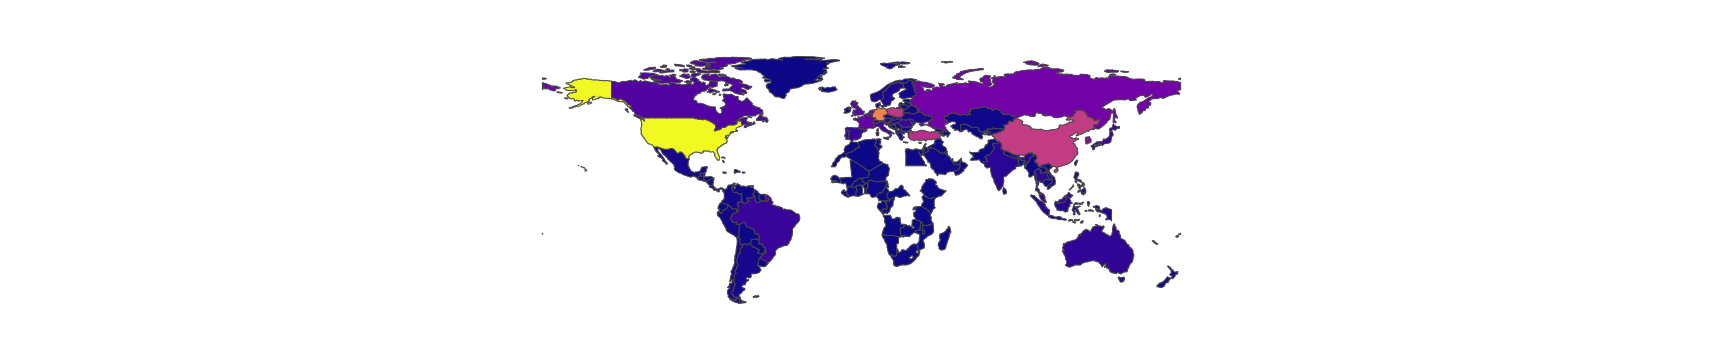

In [259]:
graph_countries_distribution(data)

In [323]:
### GRAPH TOP PROJECT DAILY PV
def graph_top_project_daily_PV(df):
    by_projects = pd.DataFrame(df.groupby(['project','datecl']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    top10 = pd.DataFrame(df.groupby(['project']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index()).sort_values(by="PV", ascending=False).head(10)
    by_projects = by_projects[by_projects['project'].isin(top10['project'])]
    
    by_projects_graph = px.area(by_projects, x="datecl", y="PV", color="project", line_group="project")
    by_projects_graph.update_traces(hovertemplate=None)
    by_projects_graph.update_layout(plot_bgcolor='white', hovermode="x", legend_title_text="Project", 
                                   xaxis={'title':'Date'},
                                   yaxis={'title':"Processing Volume",'rangemode':"tozero", 'tickformat':"$,"})
    
    return by_projects_graph

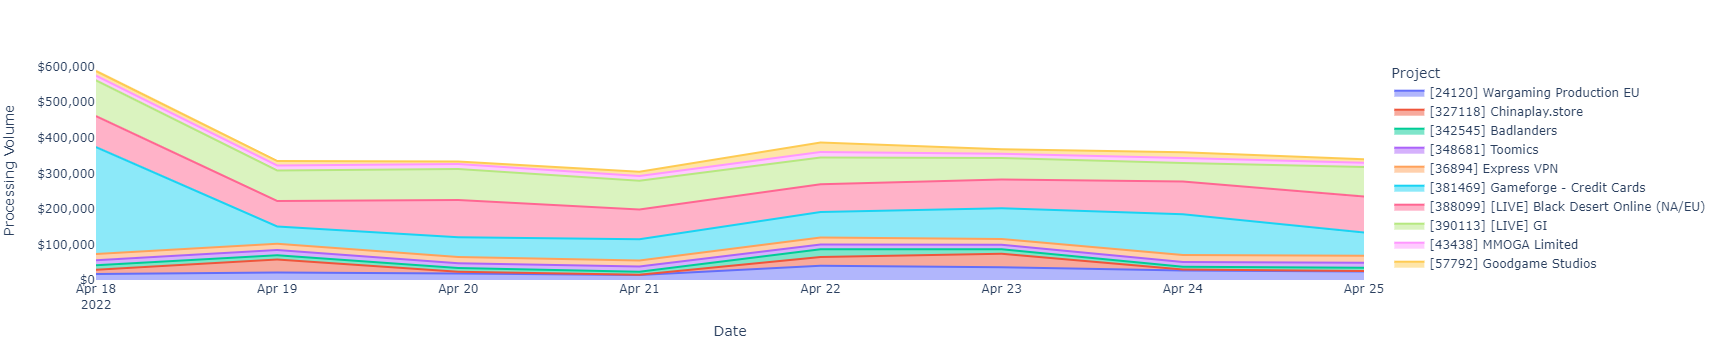

In [324]:
graph_top_project_daily_PV(data)

In [331]:
def graph_top_ps_daily_PV(df):
    by_ps = pd.DataFrame(df.groupby(['ps','datecl']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index())
    top10 = pd.DataFrame(df.groupby(['ps']).agg(PV=pd.NamedAgg(column="PV", aggfunc="sum")).reset_index()).sort_values(by="PV", ascending=False).head(10)
    by_ps = by_ps[by_ps['ps'].isin(top10['ps'])]
    
    by_ps_graph = px.area(by_ps, x="datecl", y="PV", color="ps", line_group="ps")
    by_ps_graph.update_traces(hovertemplate=None)
    by_ps_graph.update_layout(plot_bgcolor='white', hovermode="x", legend_title_text="Payment System", 
                                   xaxis={'title':'Date'},
                                   yaxis={'title':"Processing Volume",'rangemode':"tozero", 'tickformat':"$,"})
    
    return by_ps_graph

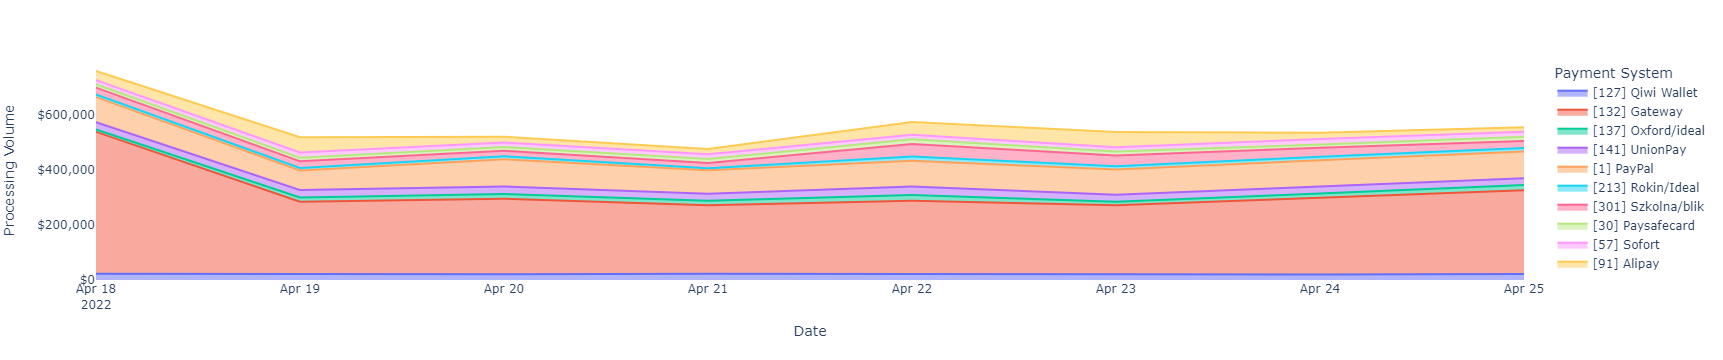

In [332]:
graph_top_ps_daily_PV(data)

In [208]:
import dash_bootstrap_components as dbc

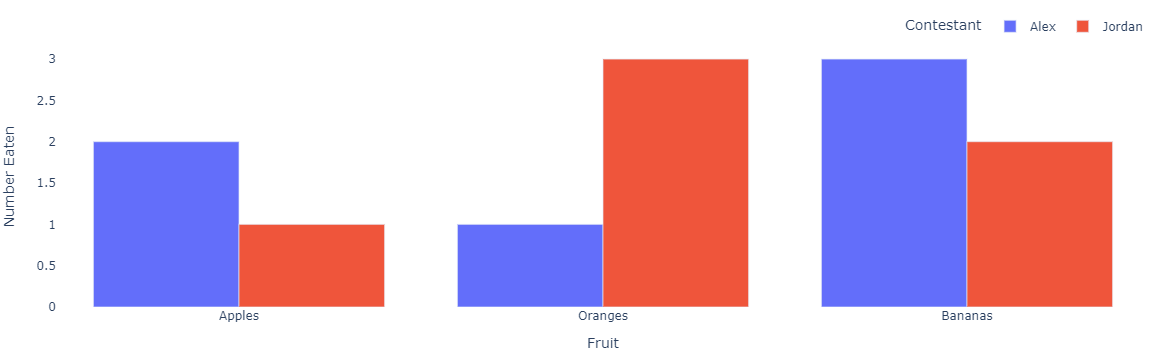

In [338]:

# 2.
df2 = px.data.gapminder()

fig2 = px.scatter(df2.query("year==2007"), x="gdpPercap", y="lifeExp",size="pop", color="continent",hover_name="country", log_x=True, size_max=60)
fig2.update_layout(plot_bgcolor='white')
fig2.update_layout(margin=dict(l=20, r=20, t=20, b=20),
                   legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
                   )

# 3.
df3 = px.data.gapminder().query("year==2007")
fig3 = px.choropleth(df3, locations="iso_alpha",
                    color="lifeExp", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                     )
fig3.update_coloraxes(showscale=False)
fig3.update_layout(margin=dict(l=0, r=0, t=0, b=0), autosize=False)
fig3.update_geos(fitbounds="locations", visible=False)

# 4.
df4 = pd.DataFrame({
  "Fruit": ["Apples", "Oranges", "Bananas", "Apples", "Oranges", "Bananas"],
  "Contestant": ["Alex", "Alex", "Alex", "Jordan", "Jordan", "Jordan"],
  "Number Eaten": [2, 1, 3, 1, 3, 2],
})
fig4 = px.bar(df4, x="Fruit", y="Number Eaten", color="Contestant", barmode="group")
fig4.update_layout(plot_bgcolor='white')
fig4.update_layout(margin=dict(l=20, r=20, t=20, b=20),
                   legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
                   )

In [339]:
app.layout = html.Div(
    [
        dbc.Row([
            dbc.Col(dbc.Row([html.H4("Bubble chart"), dcc.Graph(id='fig2',figure=fig2)]) ,md=4),
            dbc.Col(dbc.Row([html.H4("Map chart"), dcc.Graph(id='fig3',figure=fig3)]) ,md=4),
            dbc.Col(dbc.Row([html.H4("Bar chart"), dcc.Graph(id='fig4',figure=fig4)]) ,md=4),
        ])
    ]
)

In [340]:
app.run_server(mode='inline')